/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 194MB/s]
100%|██████████| 101/101 [00:42<00:00,  2.37it/s]


Epoch 1, Train Acc: 0.7282, Val Acc: 0.7714


100%|██████████| 101/101 [00:41<00:00,  2.45it/s]


Epoch 2, Train Acc: 0.8297, Val Acc: 0.8197


100%|██████████| 101/101 [00:41<00:00,  2.42it/s]


Epoch 3, Train Acc: 0.8991, Val Acc: 0.8178


100%|██████████| 101/101 [00:42<00:00,  2.40it/s]


Epoch 4, Train Acc: 0.9263, Val Acc: 0.8271


100%|██████████| 101/101 [00:41<00:00,  2.43it/s]


Epoch 5, Train Acc: 0.9313, Val Acc: 0.8587


100%|██████████| 101/101 [00:42<00:00,  2.40it/s]


Epoch 6, Train Acc: 0.9554, Val Acc: 0.8513


100%|██████████| 101/101 [00:41<00:00,  2.42it/s]


Epoch 7, Train Acc: 0.9622, Val Acc: 0.7974


100%|██████████| 101/101 [00:42<00:00,  2.40it/s]


Epoch 8, Train Acc: 0.9659, Val Acc: 0.8569


100%|██████████| 101/101 [00:41<00:00,  2.42it/s]


Epoch 9, Train Acc: 0.9666, Val Acc: 0.8773


100%|██████████| 101/101 [00:41<00:00,  2.46it/s]


Epoch 10, Train Acc: 0.9752, Val Acc: 0.8625


100%|██████████| 101/101 [00:41<00:00,  2.42it/s]


Epoch 11, Train Acc: 0.9783, Val Acc: 0.8569


100%|██████████| 101/101 [00:42<00:00,  2.40it/s]


Epoch 12, Train Acc: 0.9814, Val Acc: 0.8662


100%|██████████| 101/101 [00:41<00:00,  2.41it/s]


Epoch 13, Train Acc: 0.9864, Val Acc: 0.8253


100%|██████████| 101/101 [00:41<00:00,  2.41it/s]


Epoch 14, Train Acc: 0.9845, Val Acc: 0.8736
Early stopping triggered!
Confusion Matrix:
 [[101  34   0]
 [ 34 204   0]
 [  0   0 167]]
Classification Report:
                             precision    recall  f1-score   support

         Lung Cancer X-ray       0.75      0.75      0.75       135
                    Normal       0.86      0.86      0.86       238
unsplash-images-collection       1.00      1.00      1.00       167

                  accuracy                           0.87       540
                 macro avg       0.87      0.87      0.87       540
              weighted avg       0.87      0.87      0.87       540

Cohen's Kappa: 0.8055517310767731


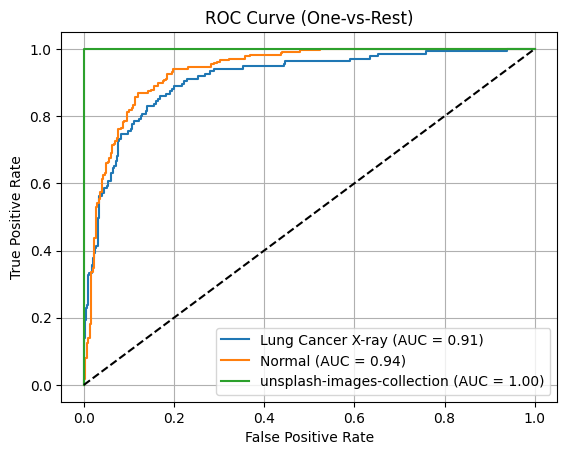

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.models import efficientnet_b3
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# ------------------------ SETTINGS ------------------------
DATA_DIR = '/kaggle/input/x-ray-dataset-with-unk/xray-dataset-lung'
BATCH_SIZE = 16
NUM_EPOCHS = 50
PATIENCE = 5
NUM_CLASSES = 3  # cancer, normal, unknown
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------ TRANSFORMS ------------------------
train_transform = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Normalize(),
    ToTensorV2(),
])
val_test_transform = A.Compose([
    A.Resize(300, 300),
    A.Normalize(),
    ToTensorV2(),
])

# Custom dataset using Albumentations
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)
        img = self.transform(image=img)['image']
        return img, label

# ------------------------ DATASET & BALANCING ------------------------
dataset = ImageFolder(DATA_DIR)
class_names = dataset.classes

# Split dataset
train_len = int(0.6 * len(dataset))
val_len = int(0.2 * len(dataset))
test_len = len(dataset) - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

# Apply transforms
train_ds = AlbumentationsDataset(train_ds, train_transform)
val_ds = AlbumentationsDataset(val_ds, val_test_transform)
test_ds = AlbumentationsDataset(test_ds, val_test_transform)

# Weighted sampler to handle imbalance
targets = [label for _, label in train_ds]
class_sample_counts = np.bincount(targets)
weights = 1. / class_sample_counts
sample_weights = [weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------ MODEL ------------------------
model = efficientnet_b3(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ------------------------ TRAINING UTILS ------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_model = None
best_acc = 0
early_stop_counter = 0

# ------------------------ TRAINING LOOP ------------------------
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered!")
            break

# Save best model
torch.save(best_model, "xray_effb3.pth")
model.load_state_dict(best_model)

# ------------------------ TEST & EVALUATIONS ------------------------
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probs = torch.softmax(outputs, 1)
        preds = torch.argmax(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Kappa Score
kappa = cohen_kappa_score(all_labels, all_preds)
print("Cohen's Kappa:", kappa)

# ROC Curve (macro average for 3-class)
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve((all_labels_np == i).astype(int), all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()
